In [153]:
import torch
import torch.nn as nn
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker
import seaborn as sns
import math
import time
import os

In [154]:
class Network(nn.Module):
    def __init__(self,num_input=2,layers=[64, 64, 64],num_output=1):
        super(Network,self).__init__()
        self.input_layer=nn.Linear(num_input,layers[0])
        self.hidden_layer=nn.ModuleList()
        for i in range(len(layers)-1):
            self.hidden_layer.append(nn.Linear(layers[i],layers[i+1]))
        self.output_layer=nn.Linear(layers[-1],num_output)
    def forward(self,out):
        out=torch.tanh(self.input_layer(out))
        for layer in self.hidden_layer:
            out=torch.tanh(layer(out))
        out=self.output_layer(out)
        return out

In [168]:
class Pinns:
    def __init__(self):
        self.device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
        self.network = Network().to(self.device)
        print("CUDA Available:", torch.cuda.is_available())

        # Physical parameter
        self.c0 = 80

        # Characteristic scales
        self.L_char = 2 * np.pi                # characteristic length
        self.T_char = self.L_char / self.c0    # characteristic time
        self.c_star = 1.0                      # non-dimensional speed

        # Non-dimensional spatial and temporal domain
        self.dx = 0.01
        self.dt = 0.01

        self.x = torch.arange(0, 1 + self.dx, self.dx)                # x* ∈ [0, 1]
        self.t = torch.arange(0, 1 / self.T_char + self.dt, self.dt)  # t* ∈ [0, 1/T_char]

        self.t_grid, self.x_grid = torch.meshgrid(self.t, self.x, indexing='ij')
        self.TX = torch.stack([self.t_grid.reshape(-1), self.x_grid.reshape(-1)], dim=1).to(self.device)
        self.TX.requires_grad = True

        self.x = self.x.to(self.device)
        self.t = self.t.to(self.device)

        # Initial and boundary conditions in non-dimensional form
        self.initial = torch.stack([torch.zeros_like(self.x), self.x], dim=1).to(self.device)
        self.u_initial = torch.sin(2 * np.pi * self.initial[:, 1]).unsqueeze(1).to(self.device)

        self.boundary_left = torch.stack([self.t, torch.zeros_like(self.t)], dim=1).to(self.device)
        self.boundary_right = torch.stack([self.t, torch.ones_like(self.t)], dim=1).to(self.device)

        # Loss function and optimizer
        self.criterion = nn.MSELoss()
        self.optimizer = torch.optim.Adam(self.network.parameters(), lr=2e-5)
        # Limited-memory Broyden-Fletcher-Goldfarb-Shanno (L-BFGS)
        self.optimizer1 = torch.optim.LBFGS(
            self.network.parameters(),
            lr=1.0,
            max_iter=1000,
            max_eval=1000,
            history_size=50,
            tolerance_grad=1e-7,
            tolerance_change=1.0 * np.finfo(float).eps,
            line_search_fn="strong_wolfe"
        )
        self.loss_history = []

    def gradients(self, input, wrt):
        grad = torch.autograd.grad(
            outputs=input,
            inputs=wrt,
            grad_outputs=torch.ones_like(input),
            create_graph=True,
            retain_graph=True
        )[0]
        return grad

    def loss(self):
        self.optimizer.zero_grad()

        u_pred = self.network(self.TX)
        du_dt = self.gradients(u_pred, self.TX)[:, 0]
        du_dx = self.gradients(u_pred, self.TX)[:, 1]
        residual = du_dt + self.c_star * du_dx

        loss_pde = self.criterion(residual, torch.zeros_like(residual))

        u_init_pred = self.network(self.initial)
        loss_ic = self.criterion(u_init_pred, self.u_initial)

        u_left = self.network(self.boundary_left)
        u_right = self.network(self.boundary_right)
        loss_bc = self.criterion(u_left, u_right)

        total_loss = loss_pde + loss_ic + loss_bc
        total_loss.backward()
        return total_loss

    def train(self, num_epochs=1000):
        self.network.train()
        for i in range(num_epochs):
            loss = self.loss()
            self.optimizer.step()
            self.loss_history.append(loss.item())
            if i % 10 == 0:
                print(f"Epoch {i}, Loss: {loss.item():.8f}")
            if i % 1000 == 0:
                torch.save(self.network.state_dict(), r'C:/Users/hossein/Result/advection/1-Pinns/model')
        #self.optimizer1.step(self.loss())

    def plot(self):
        self.network.eval()
        with torch.no_grad():
            u = self.network(self.TX).cpu().numpy().reshape(len(self.t), len(self.x))
            t_vals = self.t_grid.cpu().numpy()
            x_vals = self.x_grid.cpu().numpy()
         
        plt.rcParams.update({
            "font.family": "Times New Roman",
            "font.style": "italic"
        })

        # Compute analytical (exact) solution
        T_mesh, X_mesh = np.meshgrid(self.t.cpu().numpy(), self.x.cpu().numpy(), indexing='ij')
        u_exact = np.sin(2 * np.pi * (X_mesh - T_mesh))
        
        plt.figure(figsize=(6, 5))
        cp1 = plt.contourf(x_vals, t_vals, u, levels=50, cmap='jet')
        plt.colorbar(cp1)
        plt.title("AD-PINNs", fontsize=13)
        plt.xlabel("x", fontsize=14)
        plt.ylabel("t", fontsize=14)
        plt.grid(True)
        plt.savefig("C:/Users/hossein/Result/advection/1-Pinns/u_Pinn.png", dpi=300)
        plt.show()
        
        plt.figure(figsize=(6, 5))
        cp2 = plt.contourf(x_vals, t_vals, u_exact, levels=50, cmap='jet')
        plt.colorbar(cp2)
        plt.title("Exact Solution u", fontsize=13)
        plt.xlabel("x", fontsize=14)
        plt.ylabel("t", fontsize=14)
        plt.grid(True)
        plt.savefig("C:/Users/hossein/Result/advection/1-Pinns/u_exact.png", dpi=300)
        plt.tight_layout()
        plt.show()
    
        error = np.abs(u - u_exact)
        rel_error = np.linalg.norm(error) / np.linalg.norm(u_exact)
    
        plt.figure(figsize=(6, 5))
        err = plt.contourf(x_vals, t_vals, error, levels=50, cmap="jet")
        plt.colorbar(err, format="%.2e")
        plt.title("Absolute Error", fontsize=13)
        plt.xlabel("x", fontsize=14)
        plt.ylabel("t", fontsize=14)
        plt.grid(True)
        plt.savefig("C:/Users/hossein/Result/advection/1-Pinns/u_error.png", dpi=300)
        plt.show()
        
        
    def plot_loss(self):
        plt.figure(figsize=(8, 5))
        plt.plot(self.loss_history, label='Loss')
        plt.xlabel('Epoch')
        plt.ylabel('Loss')
        plt.title('Loss Function History')
        plt.yscale("log")
        plt.grid(True)
        plt.legend()
        plt.show()

        # df = pd.DataFrame({"loss": self.loss_history})
        # df.to_csv("C:/Users/hossein/Result/advection/1-Pinns/loss_history5.csv", index=False)

CUDA Available: True
Epoch 0, Loss: 0.00028092


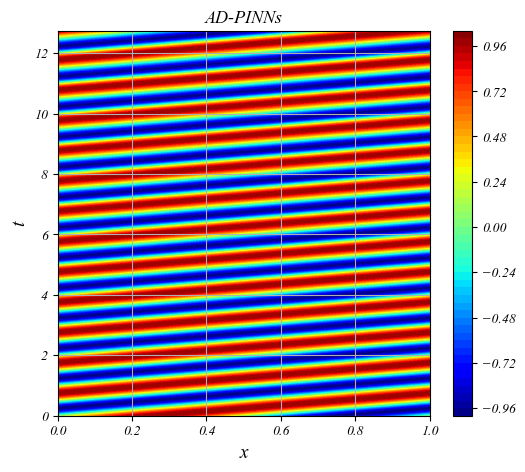

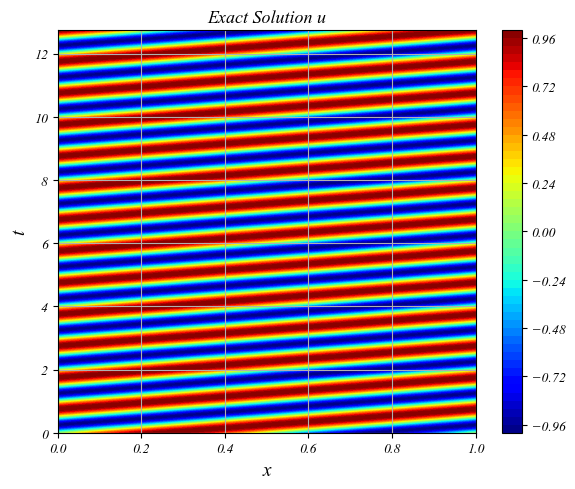

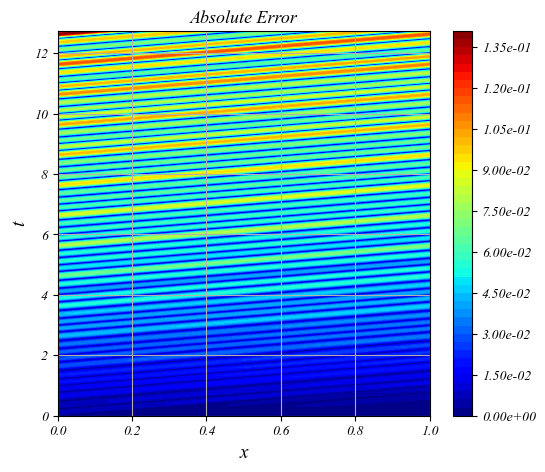

In [169]:
net = Pinns()
net.network.load_state_dict(torch.load(r'C:/Users/hossein/Result/advection/1-Pinns/model'))
net.train(num_epochs=1)
net.plot()